### Step 1: Data acquisition

This section of code collects metrics from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.
The JSON responses are stored into separte files in the data-raw folder.

In [1]:
import requests, json

start, end = '2007120100', '2018090100'
site = 'en.wikipedia.org'
common = 'https://wikimedia.org/api/rest_v1/metrics'
raw_data_path = './data-raw/'

filenames = [
    f'pagecounts_desktop-site_{start}-{end}',
    f'pagecounts_mobile-site_{start}-{end}',
    f'pageviews_mobile-web_{start}-{end}',
    f'pageviews_mobile-app_{start}-{end}',
    f'pageviews_desktop_{start}-{end}'
]
apis = [
    f'{common}/legacy/pagecounts/aggregate/{site}/desktop-site/monthly/{start}/{end}',
    f'{common}/legacy/pagecounts/aggregate/{site}/mobile-site/monthly/{start}/{end}',
    f'{common}/pageviews/aggregate/{site}/mobile-web/user/monthly/{start}/{end}',
    f'{common}/pageviews/aggregate/{site}/mobile-app/user/monthly/{start}/{end}',
    f'{common}/pageviews/aggregate/{site}/desktop/user/monthly/{start}/{end}'
]
headers = {
    'user-agent': 'https://github.com/viv-r',
    'from': 'vivr@uw.edu'
}

for file, api in zip(filenames, apis):
    response = requests.get(headers=headers, url=api)
    if not response.ok:
        print(f'Request {api} failed')
        
    with open(raw_data_path + file, 'w+') as f:
        f.write(json.dumps(response.json()['items']))

### Step 2. Data processing

This section merges the 5 files generated above and transforms the columns into a format that we require for analysis.

In [2]:
import pandas as pd

def read(i):
    return pd.read_json(raw_data_path + filenames[i], convert_dates=False)

datasets = dict(
    pagecount_desktop_views = read(0),
    pagecount_mobile_views = read(1),
    pageview_mobileapp_views = read(2),
    pageview_mobileweb_views = read(3),
    pageview_desktop_views = read(4),
)

series = []

for k in datasets:
    datasets[k].index = datasets[k]['timestamp'].astype(str).str.slice(0, 6)
    colname = 'views' if 'views' in datasets[k].columns else 'count'
    series.append(datasets[k][[colname]].rename({'views': k, 'count': k}, axis=1))
    
cleaned = pd.concat(series, axis=1).fillna(0)
cleaned['year'] = cleaned.index.str.slice(0, 4)
cleaned['month'] = cleaned.index.str.slice(4, 6)
cleaned['pageview_mobile_views'] = cleaned.pageview_mobileweb_views + cleaned.pageview_mobileapp_views
cleaned['pageview_mobile_views'] = cleaned.pageview_mobileweb_views + cleaned.pageview_mobileapp_views
cleaned['pageview_all_views'] = cleaned.pageview_mobile_views + cleaned.pageview_desktop_views
cleaned['pagecount_all_views'] = cleaned.pagecount_desktop_views + cleaned.pagecount_mobile_views
cleaned = cleaned.drop(['pageview_mobileapp_views', 'pageview_mobileweb_views'], axis=1)
cleaned.to_csv(f'./data-cleaned/en-wikipedia_traffic_{start}-{end}.csv')

cleaned.head()

,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,year,month,pageview_mobile_views,pageview_all_views,pagecount_all_views
200712,2.998332e+09,0.0,0.0,2007,12,0.0,0.0,2.998332e+09
200801,4.930903e+09,0.0,0.0,2008,01,0.0,0.0,4.930903e+09
200802,4.818394e+09,0.0,0.0,2008,02,0.0,0.0,4.818394e+09
200803,4.955406e+09,0.0,0.0,2008,03,0.0,0.0,4.955406e+09
200804,5.159162e+09,0.0,0.0,2008,04,0.0,0.0,5.159162e+09


### Step 3: Analysis

We generate a plot of the datset. Mobile and Desktop views are shown as dotted green and blue lines respectively. Total counts are in black.

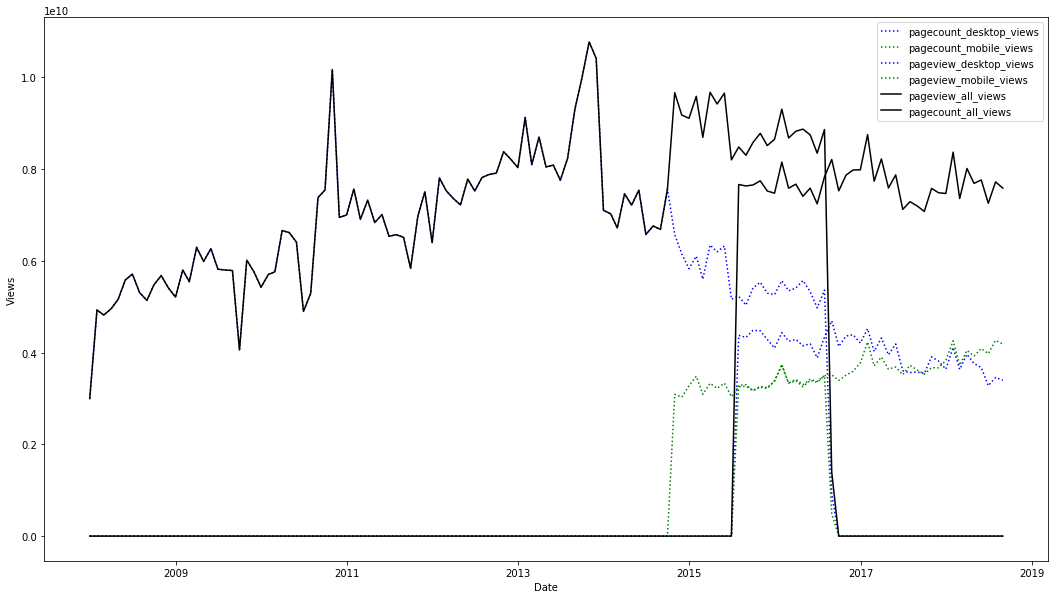

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

x = pd.date_range('2007-12', '2018-09', freq='M')
fig = plt.figure(figsize=(18, 10))
plt.plot(x, cleaned['pagecount_desktop_views'], 'b:')
plt.plot(x, cleaned['pagecount_mobile_views'], 'g:')
plt.plot(x, cleaned['pageview_desktop_views'], 'b:')
plt.plot(x, cleaned['pageview_mobile_views'], 'g:')
plt.plot(x, cleaned['pageview_all_views'] , 'k')
plt.plot(x, cleaned['pagecount_all_views'], 'k')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()
fig.savefig('./views_graph.jpg')